# Unigram tokenization

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [1]:
!pip install datasets evaluate transformers[sentencepiece]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.7.0
    Uninstalling fsspec-2025.7.0:
      Successfully uninstalled fsspec-2025.7.0


The Unigram algorithm is used in combination with SentencePiece, which is the tokenization algorithm used by models like AlBERT, T5, mBART, Big Bird, and XLNet.

SentencePiece addresses the fact that not all languages use spaces to separate words. Instead, SentencePiece treats the input as a raw input stream which includes the space in the set of characters to use. Then it can use the Unigram algorithm to construct the appropriate vocabulary.

**Training algorithm**

Compared to BPE and WordPiece, Unigram works in the other direction: it starts from a big vocabulary and removes tokens from it until it reaches the desired vocabulary size. There are several options to use to build that base vocabulary: we can take the most common substrings in pre-tokenized words, for instance, or apply BPE on the initial corpus with a large vocabulary size.

At each step of the training, the Unigram algorithm computes a loss over the corpus given the current vocabulary. Then, for each symbol in the vocabulary, the algorithm computes how much the overall loss would increase if the symbol was removed, and looks for the symbols that would increase it the least. Those symbols have a lower effect on the overall loss over the corpus, so in a sense they are “less needed” and are the best candidates for removal.

This is all a very costly operation, so we don’t just remove the single symbol associated with the lowest loss increase, but the
p
p (\(p\) being a hyperparameter you can control, usually 10 or 20) percent of the symbols associated with the lowest loss increase. This process is then repeated until the vocabulary has reached the desired size.

Note that we never remove the base characters, to make sure any word can be tokenized.

Now, this is still a bit vague: the main part of the algorithm is to compute a loss over the corpus and see how it changes when we remove some tokens from the vocabulary, but we haven’t explained how to do this yet. This step relies on the tokenization algorithm of a Unigram model, so we’ll dive into this next.

We’ll reuse the corpus from the previous examples:



Implementing Unigram
Now let’s implement everything we’ve seen so far in code. Like with BPE and WordPiece, this is not an efficient implementation of the Unigram algorithm (quite the opposite), but it should help you understand it a bit better.

We will use the same corpus as before as an example:

In [2]:
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)

(('hug', 10), ('pug', 5), ('pun', 12), ('bun', 4), ('hugs', 5))

and for this example, we will take all strict substrings for the initial vocabulary :


In [3]:
["h", "u", "g", "hu", "ug", "p", "pu", "n", "un", "b", "bu", "s", "hug", "gs", "ugs"]

['h',
 'u',
 'g',
 'hu',
 'ug',
 'p',
 'pu',
 'n',
 'un',
 'b',
 'bu',
 's',
 'hug',
 'gs',
 'ugs']

**Tokenization algorithm**

A Unigram model is a type of language model that considers each token to be independent of the tokens before it. It’s the simplest language model, in the sense that the probability of token X given the previous context is just the probability of token X. So, if we used a Unigram language model to generate text, we would always predict the most common token.

The probability of a given token is its frequency (the number of times we find it) in the original corpus, divided by the sum of all frequencies of all tokens in the vocabulary (to make sure the probabilities sum up to 1). For instance, "ug" is present in "hug", "pug", and "hugs", so it has a frequency of 20 in our corpus.

Here are the frequencies of all the possible subwords in the vocabulary:



```
("h", 15) ("u", 36) ("g", 20) ("hu", 15) ("ug", 20) ("p", 17) ("pu", 17) ("n", 16)
("un", 16) ("b", 4) ("bu", 4) ("s", 5) ("hug", 15) ("gs", 5) ("ugs", 5)
```



So, the sum of all frequencies is 210, and the probability of the subword "ug" is thus 20/210.

✏️ Now your turn! Write the code to compute the frequencies above and double-check that the results shown are correct, as well as the total sum.

Now, to tokenize a given word, we look at all the possible segmentations into tokens and compute the probability of each according to the Unigram model. Since all tokens are considered independent, this probability is just the product of the probability of each token. For instance, the tokenization ["p", "u", "g"] of "pug" has the probability:




```
P([‘‘p",‘‘u",‘‘g"])=P(‘‘p")×P(‘‘u")×P(‘‘g")= 210 5​× 210 36​× 210 20​=0.000389
```




Comparatively, the tokenization ["pu", "g"] has the probability:


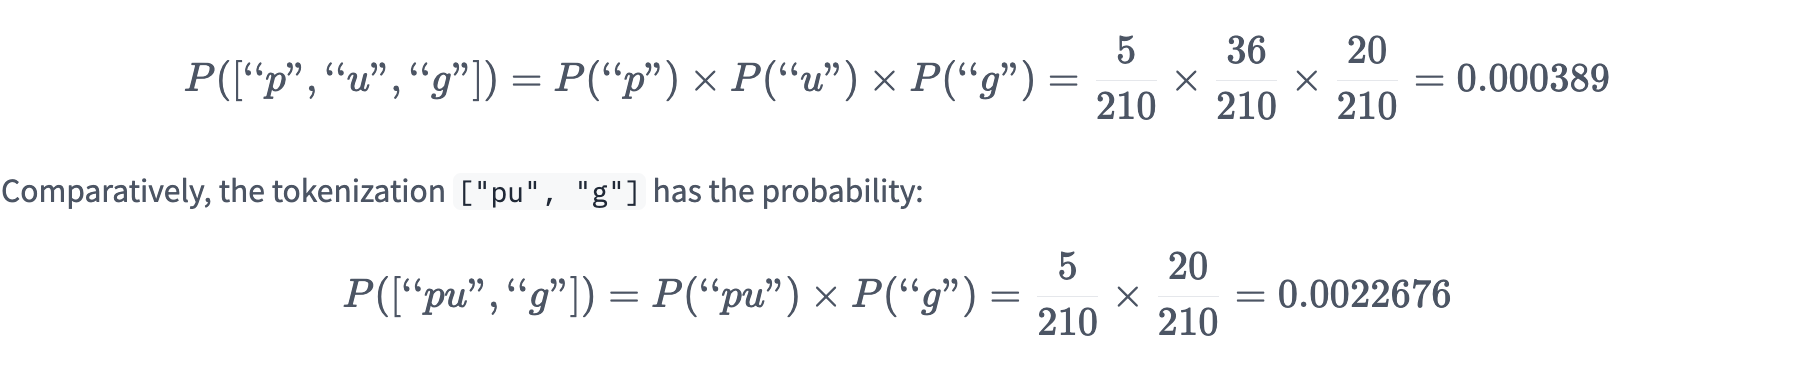


so that one is way more likely. In general, tokenizations with the least tokens possible will have the highest probability (because of that division by 210 repeated for each token), which corresponds to what we want intuitively: to split a word into the least number of tokens possible.

The tokenization of a word with the Unigram model is then the tokenization with the highest probability. In the example of "pug", here are the probabilities we would get for each possible segmentation:



```
["p", "u", "g"] : 0.000389
["p", "ug"] : 0.0022676
["pu", "g"] : 0.0022676
```



So, "pug" would be tokenized as ["p", "ug"] or ["pu", "g"], depending on which of those segmentations is encountered first (note that in a larger corpus, equality cases like this will be rare).

In this case, it was easy to find all the possible segmentations and compute their probabilities, but in general it’s going to be a bit harder. There is a classic algorithm used for this, called the Viterbi algorithm. Essentially, we can build a graph to detect the possible segmentations of a given word by saying there is a branch from character a to character b if the subword from a to b is in the vocabulary, and attribute to that branch the probability of the subword.

To find the path in that graph that is going to have the best score the Viterbi algorithm determines, for each position in the word, the segmentation with the best score that ends at that position. Since we go from the beginning to the end, that best score can be found by looping through all subwords ending at the current position and then using the best tokenization score from the position this subword begins at. Then, we just have to unroll the path taken to arrive at the end.

Let’s take a look at an example using our vocabulary and the word "unhug". For each position, the subwords with the best scores ending there are the following:



```
Character 0 (u): "u" (score 0.171429)
Character 1 (n): "un" (score 0.076191)
Character 2 (h): "un" "h" (score 0.005442)
Character 3 (u): "un" "hu" (score 0.005442)
Character 4 (g): "un" "hug" (score 0.005442)
```



**Back to training**

Now that we have seen how the tokenization works, we can dive a little more deeply into the loss used during training. At any given stage, this loss is computed by tokenizing every word in the corpus, using the current vocabulary and the Unigram model determined by the frequencies of each token in the corpus (as seen before).

Each word in the corpus has a score, and the loss is the negative log likelihood of those scores — that is, the sum for all the words in the corpus of all the -log(P(word)).

Let’s go back to our example with the following corpus:



```
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
```
The tokenization of each word with their respective scores is:


```
"hug": ["hug"] (score 0.071428)
"pug": ["pu", "g"] (score 0.007710)
"pun": ["pu", "n"] (score 0.006168)
"bun": ["bu", "n"] (score 0.001451)
"hugs": ["hug", "s"] (score 0.001701)
```
So the loss is:



```
10 * (-log(0.071428)) + 5 * (-log(0.007710)) + 12 * (-log(0.006168)) + 4 * (-log(0.001451)) + 5 * (-log(0.001701)) = 169.8
```
Now we need to compute how removing each token affects the loss. This is rather tedious, so we’ll just do it for two tokens here and save the whole process for when we have code to help us. In this (very) particular case, we had two equivalent tokenizations of all the words: as we saw earlier, for example, "pug" could be tokenized ["p", "ug"] with the same score. Thus, removing the "pu" token from the vocabulary will give the exact same loss.

On the other hand, removing "hug" will make the loss worse, because the tokenization of "hug" and "hugs" will become:



```
"hug": ["hu", "g"] (score 0.006802)
"hugs": ["hu", "gs"] (score 0.001701)
```
These changes will cause the loss to rise by:



```
- 10 * (-log(0.071428)) + 10 * (-log(0.006802)) = 23.5
```








**Implementing Unigram**

Now let’s implement everything we’ve seen so far in code. Like with BPE and WordPiece, this is not an efficient implementation of the Unigram algorithm (quite the opposite), but it should help you understand it a bit better.

We will use the same corpus as before as an example:

In [4]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

This time, we will use xlnet-base-cased as our model:

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Like for BPE and WordPiece, we begin by counting the number of occurrences of each word in the corpus:

In [6]:
from collections import defaultdict

word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

word_freqs

defaultdict(int,
            {'▁This': 3,
             '▁is': 2,
             '▁the': 1,
             '▁Hugging': 1,
             '▁Face': 1,
             '▁Course.': 1,
             '▁chapter': 1,
             '▁about': 1,
             '▁tokenization.': 1,
             '▁section': 1,
             '▁shows': 1,
             '▁several': 1,
             '▁tokenizer': 1,
             '▁algorithms.': 1,
             '▁Hopefully,': 1,
             '▁you': 1,
             '▁will': 1,
             '▁be': 1,
             '▁able': 1,
             '▁to': 1,
             '▁understand': 1,
             '▁how': 1,
             '▁they': 1,
             '▁are': 1,
             '▁trained': 1,
             '▁and': 1,
             '▁generate': 1,
             '▁tokens.': 1})

Then, we need to initialize our vocabulary to something larger than the vocab size we will want at the end. We have to include all the basic characters (otherwise we won’t be able to tokenize every word), but for the bigger substrings we’ll only keep the most common ones, so we sort them by frequency:

In [7]:
char_freqs = defaultdict(int)
subwords_freqs = defaultdict(int)
for word, freq in word_freqs.items():
    for i in range(len(word)):
        char_freqs[word[i]] += freq
        # Loop through the subwords of length at least 2
        for j in range(i + 2, len(word) + 1):
            subwords_freqs[word[i:j]] += freq

# Sort subwords by frequency
sorted_subwords = sorted(subwords_freqs.items(), key=lambda x: x[1], reverse=True)
sorted_subwords[:10]

[('▁t', 7),
 ('is', 5),
 ('er', 5),
 ('▁a', 5),
 ('▁to', 4),
 ('to', 4),
 ('en', 4),
 ('▁T', 3),
 ('▁Th', 3),
 ('▁Thi', 3)]

We group the characters with the best subwords to arrive at an initial vocabulary of size 300:

In [8]:
token_freqs = list(char_freqs.items()) + sorted_subwords[: 300 - len(char_freqs)]
token_freqs = {token: freq for token, freq in token_freqs}

Next, we compute the sum of all frequencies, to convert the frequencies into probabilities. For our model we will store the logarithms of the probabilities, because it’s more numerically stable to add logarithms than to multiply small numbers, and this will simplify the computation of the loss of the model:

In [9]:
from math import log

total_sum = sum([freq for token, freq in token_freqs.items()])
model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

Now the main function is the one that tokenizes words using the Viterbi algorithm. As we saw before, that algorithm computes the best segmentation of each substring of the word, which we will store in a variable named best_segmentations. We will store one dictionary per position in the word (from 0 to its total length), with two keys: the index of the start of the last token in the best segmentation, and the score of the best segmentation. With the index of the start of the last token, we will be able to retrieve the full segmentation once the list is completely populated.

Populating the list is done with just two loops: the main loop goes over each start position, and the second loop tries all substrings beginning at that start position. If the substring is in the vocabulary, we have a new segmentation of the word up until that end position, which we compare to what is in best_segmentations.

Once the main loop is finished, we just start from the end and hop from one start position to the next, recording the tokens as we go, until we reach the start of the word:

In [10]:
def encode_word(word, model):
    best_segmentations = [{"start": 0, "score": 1}] + [
        {"start": None, "score": None} for _ in range(len(word))
    ]
    for start_idx in range(len(word)):
        # This should be properly filled by the previous steps of the loop
        best_score_at_start = best_segmentations[start_idx]["score"]
        for end_idx in range(start_idx + 1, len(word) + 1):
            token = word[start_idx:end_idx]
            if token in model and best_score_at_start is not None:
                score = model[token] + best_score_at_start
                # If we have found a better segmentation ending at end_idx, we update
                if (
                    best_segmentations[end_idx]["score"] is None
                    or best_segmentations[end_idx]["score"] > score
                ):
                    best_segmentations[end_idx] = {"start": start_idx, "score": score}

    segmentation = best_segmentations[-1]
    if segmentation["score"] is None:
        # We did not find a tokenization of the word -> unknown
        return ["<unk>"], None

    score = segmentation["score"]
    start = segmentation["start"]
    end = len(word)
    tokens = []
    while start != 0:
        tokens.insert(0, word[start:end])
        next_start = best_segmentations[start]["start"]
        end = start
        start = next_start
    tokens.insert(0, word[start:end])
    return tokens, score

We can already try our initial model on some words:

In [11]:
print(encode_word("Hopefully", model))
print(encode_word("This", model))

(['H', 'o', 'p', 'e', 'f', 'u', 'll', 'y'], 41.5157494601402)
(['This'], 6.288267030694535)


Now it’s easy to compute the loss of the model on the corpus!

In [12]:
def compute_loss(model):
    loss = 0
    for word, freq in word_freqs.items():
        _, word_loss = encode_word(word, model)
        loss += freq * word_loss
    return loss

We can check it works on the model we have:

In [13]:
compute_loss(model)

413.10377642940875

Computing the scores for each token is not very hard either; we just have to compute the loss for the models obtained by deleting each token:

In [14]:
import copy


def compute_scores(model):
    scores = {}
    model_loss = compute_loss(model)
    for token, score in model.items():
        # We always keep tokens of length 1
        if len(token) == 1:
            continue
        model_without_token = copy.deepcopy(model)
        _ = model_without_token.pop(token)
        scores[token] = compute_loss(model_without_token) - model_loss
    return scores

We can try it on a given token:

In [15]:
scores = compute_scores(model)

Since "ll" is used in the tokenization of "Hopefully", and removing it will probably make us use the token "l" twice instead, we expect it will have a positive loss. "his" is only used inside the word "This", which is tokenized as itself, so we expect it to have a zero loss. Here are the results:

In [16]:
print(scores["ll"])
print(scores["his"])

6.376412403623874
0.0


💡 This approach is very inefficient, so SentencePiece uses an approximation of the loss of the model without token X: instead of starting from scratch, it just replaces token X by its segmentation in the vocabulary that is left. This way, all the scores can be computed at once at the same time as the model loss.

With all of this in place, the last thing we need to do is add the special tokens used by the model to the vocabulary, then loop until we have pruned enough tokens from the vocabulary to reach our desired size:


In [17]:
percent_to_remove = 0.1
while len(model) > 100:
    scores = compute_scores(model)
    sorted_scores = sorted(scores.items(), key=lambda x: x[1])
    # Remove percent_to_remove tokens with the lowest scores.
    for i in range(int(len(model) * percent_to_remove)):
        _ = token_freqs.pop(sorted_scores[i][0])

    total_sum = sum([freq for token, freq in token_freqs.items()])
    model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

Then, to tokenize some text, we just need to apply the pre-tokenization and then use our encode_word() function:

In [18]:
def tokenize(text, model):
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in words_with_offsets]
    encoded_words = [encode_word(word, model)[0] for word in pre_tokenized_text]
    return sum(encoded_words, [])


tokenize("This is the Hugging Face course.", model)

['▁This',
 '▁is',
 '▁the',
 '▁Hugging',
 '▁Face',
 '▁',
 'c',
 'ou',
 'r',
 's',
 'e',
 '.']

The XLNetTokenizer uses SentencePiece which is why the "_" character is included. To decode with SentencePiece, concatenate all the tokens and replace "_" with a space.

That’s it for Unigram! Hopefully by now you’re feeling like an expert in all things tokenizer. In the next section, we will delve into the building blocks of the 🤗 Tokenizers library, and show you how you can use them to build your own tokenizer.